In [1]:
import os
import sys
import glob
import gzip
import numpy as np
import pandas as pd
import xarray as xr
import geopandas as gpd

import cartopy.feature as cf
import cartopy.crs as ccrs

from matplotlib import patches
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Hourly Accumulation for MVK

In [2]:
year = 2024

In [3]:
dir_base = os.path.join('/','media','arturo','Arturo','Data','Brazil','GSMaP')

In [4]:
lat = np.arange(-55,13,0.1)
lon = np.arange(-83,-33,0.1)
lon2d, lat2d = np.meshgrid(lon, lat)

In [6]:
# mm = 1 # Month to process

for mm in range(1,13):

    month = str(mm).zfill(2)

    start = pd.Timestamp(f'2024-{month}-01 00:00')
    end = (start + pd.offsets.MonthEnd(1)).replace(hour=23)
    
    TIME_REF = pd.date_range(start=start, end=end, freq='1h')
    print(f'Number of times: {len(TIME_REF)}')

    month_dir = os.path.join(dir_base, 'MVK', 'raw', str(year), month)

    days_dir = [f for f in os.listdir(month_dir) if os.path.isdir(os.path.join(month_dir, f))]

    MVK = np.zeros([len(days_dir)*24, 680, 500], dtype=np.float32)
    count = 0
    for day in range(len(days_dir)):#len(days_dir)
        days_files = glob.glob(os.path.join(month_dir, days_dir[day],'*.nc'))

        for hh in range(len(days_files)):
            with gzip.open(days_files[hh], mode='rb') as handle:
                MVK_tmp = np.frombuffer(handle.read(), dtype=np.float32).reshape(680, 500)
            MVK[count,:,:] = MVK_tmp
            count += 1

    MVK = MVK[:,::-1,:]

    PRE_xr = xr.Dataset(data_vars={"PRE": (("time","lat","lon"), MVK)},
                        coords={'time': TIME_REF, 'lat': lat, 'lon': lon},
                        attrs=dict(description=f'Daily GSMaP-MVK 1 hour precipitation for days in month 2024/{month} in SA',))

    PRE_xr.PRE.attrs["units"] = "mm/h"
    PRE_xr.PRE.attrs["long_name"] = "precipitation"
    PRE_xr.PRE.attrs["origname"] = "precipitation"

    PRE_xr.lat.attrs["units"] = "degrees_north"
    PRE_xr.lat.attrs["long_name"] = "Latitude"

    PRE_xr.lon.attrs["units"] = "degrees_east"
    PRE_xr.lon.attrs["long_name"] = "Longitude"

    PRE_out = os.path.join(dir_base, 'MVK', 'hourly', f'GSMaP_MVK_SA_1h_2024_{month}.nc')
    print(f'Export PRE data to {PRE_out}')
    PRE_xr.to_netcdf(PRE_out)

Number of times: 744
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_01.nc
Number of times: 696
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_02.nc
Number of times: 744
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_03.nc
Number of times: 720
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_04.nc
Number of times: 744
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_05.nc
Number of times: 720
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_06.nc
Number of times: 744
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_07.nc
Number of times: 744
Export PRE data to /media/arturo/Arturo/Data/Brazil/GSMaP/MVK/hourly/GSMaP_MVK_SA_1h_2024_08.nc
Number of times: 720
Export PRE data to /media/arturo/Arturo/Dat

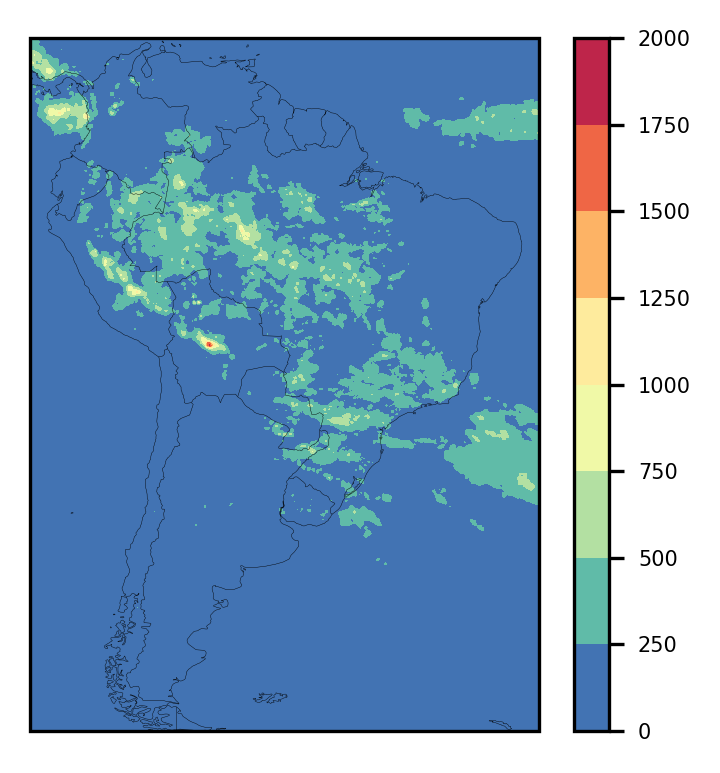

In [7]:
proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(3,3),dpi=300)
gs = gridspec.GridSpec(1,1)

#==================================================================================================
ax1 = plt.subplot(gs[0, 0], projection = proj)
ax1.add_feature(cf.COASTLINE,linewidth=0.1, linestyle='-',edgecolor='k')
ax1.add_feature(cf.BORDERS, linewidth=0.1, linestyle='-', edgecolor='k')
a1 = ax1.contourf(lon2d, lat2d, np.nansum(MVK,axis=0), cmap='Spectral_r')
cbar = plt.colorbar(a1, ax=ax1, orientation='vertical', pad=0.05, aspect=20)
cbar.ax.tick_params(labelsize=5)